In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm 
%matplotlib inline

In [2]:
def func(x):
    return x[0]*x[1] + np.log(x[1]**4 * x[2]**2) - x[0]**3 + np.sin(x[2]) + 500. 

In [18]:
N = 100
a = 0
b = 10
#initial_set = (b-a)*np.random.rand(N,3) + a
#initial_labels = np.fromiter(map(func, initial_set), np.float64).reshape(-1, 1)

unlabeled_data = (b-a)*np.random.rand(N**3,3) + a
test_labels = np.fromiter(map(func, unlabeled_data), np.float64).reshape(-1,1)

In [5]:
def sample_train(X, y):
    rand_ind = np.random.choice(len(y), int(len(y) * 0.8), replace=True)
    return X[rand_ind], y[rand_ind]

In [21]:
class committee(object):
    def __init__(self, C):
        self.C = C
        
    def fit(self, X, y):
        self.models = []
        for idx in range(self.C):
            clf = DecisionTreeRegressor()
            clf.fit(*sample_train(X, y))
            self.models.append(clf)
            
    def predict(self, X):
        committee_predictions = np.array([m.predict(X) for m in self.models]).T
        median_predict = np.percentile(committee_predictions, 50, axis=1)
        return median_predict
    
    def get_uncertain(self, X):
        committee_predictions = np.array([m.predict(X) for m in self.models]).T
        inter_quantile = (np.percentile(committee_predictions, 75, axis=1) - 
                          np.percentile(committee_predictions, 25, axis=1))
        #print(committee_predictions)
        std = np.std(committee_predictions, axis=1)
        #print(np.sort(std))
        return np.argsort(std)[::-1]

In [22]:
def reveal_unlabeled(X, y, unlabeled_data, indices):
    revealed_data = unlabeled_data[indices]
    revealed_labels = np.fromiter(map(func, revealed_data), np.float64).reshape(-1,1)
    X = np.vstack((X, revealed_data))
    y = np.vstack((y, revealed_labels))
    unlabeled_data = np.delete(unlabeled_data, indices, axis=0)
    return X, y, unlabeled_data



C = 10
M = 30
reveal_count = 100#int(N**3 * 0.3) // M 
unscertainty_error = []
random_sampling_error = []

cur_unlabeled = unlabeled_data
cur_labels = test_labels

mask = (np.random.rand(cur_unlabeled.shape[0]) > 0.95)

X_train_uncert = unlabeled_data[mask]
y_train_uncert = test_labels[mask]

X_train_random = X_train_uncert
y_train_random = y_train_uncert

cur_unlabeled_uncert = cur_unlabeled[~mask]
cur_unlabeled_random = cur_unlabeled[~mask]
cur_labels = cur_labels[~mask]


mask = (np.random.rand(cur_unlabeled_uncert.shape[0]) > 0.9)
X_test = cur_unlabeled_uncert[mask]
y_test = cur_labels[mask]



for idx in tqdm(range(M)):
    com = committee(10)
    com.fit(*sample_train(X_train_uncert, y_train_uncert))
    answer = com.predict(X_test)
    most_uncertain = com.get_uncertain(cur_unlabeled_uncert)[0:reveal_count]
    X_train_uncert, y_train_uncert, cur_unlabeled_uncert = reveal_unlabeled(X_train_uncert, 
                                                                     y_train_uncert, 
                                                                     cur_unlabeled_uncert, 
                                                                     most_uncertain)
    
    unscertainty_error.append(mean_squared_error(y_test, answer))

for idx in tqdm(range(M)):
    com = committee(10)
    com.fit(*sample_train(X_train_random, y_train_random))
    answer = com.predict(X_test)
    most_uncertain = np.random.choice(len(cur_unlabeled_random), reveal_count, replace=False)
    X_train_random, y_train_random, cur_unlabeled_random = reveal_unlabeled(X_train_random, 
                                                                     y_train_random, 
                                                                     cur_unlabeled_random, 
                                                                     most_uncertain)
    
    random_sampling_error.append(mean_squared_error(y_test, answer))
    

A Jupyter Widget

A Jupyter Widget

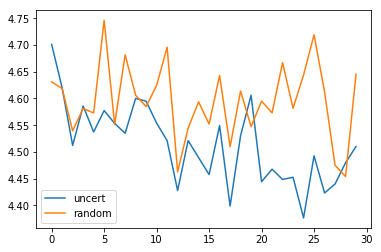

In [20]:
plt.plot(unscertainty_error, label="uncert")
plt.plot(random_sampling_error, label="random")
plt.legend()

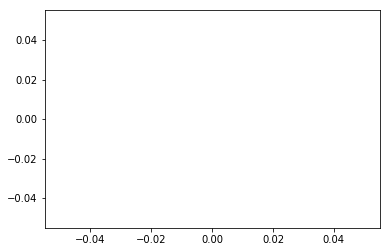

In [157]:
unlabeled_data.shape

(2999980,)

In [6]:
mask = (np.random.rand(130000) > 0.99999)

In [8]:
np.where(mask == True)

(array([28680]),)

In [62]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
from collections import namedtuple, Counter
from itertools import groupby
from sklearn.externals import joblib
from collections import Counter
from functools import reduce
from scipy.optimize import fmin
import sklearn
import sklearn.cluster

def preprocess(X):
    return np.concatenate([
        X,
        np.exp(X),
        np.log(X),
        np.sin(X),
        np.sqrt(X),
        np.square(X),
        np.cbrt(X)
    ], axis=1)


class ActiveTree(BaseEstimator, RegressorMixin):
    def __init__(self, lr=1e-1, k=1000, max_depth=10, percentile=0.75, sample_num_near=10, sample_num_random=10, cluster_num=10, sample_range=1.0):
        self.lr = lr
        self.k = k
        self.max_depth = max_depth
        self.percentile = percentile
        self.sample_num_near = sample_num_near
        self.sample_num_random = sample_num_random
        self.cluster_num = cluster_num
        self.sample_range = sample_range

    def fit(self, X, y, U):
        y = np.log(np.clip(y, 1e-10, None))
        self.model = DecisionTreeRegressor(max_depth=self.max_depth)
        self.B = RandomForestRegressor(n_estimators=10)
        self.X, self.y = X, y

        self.model.fit(self.X, self.y)
        self.B.fit(preprocess(self.X), self.y)
        self.U = U
        return self

    def partial_fit(self, X, y):
        y = np.log(np.clip(y, 1e-10, None))
        self.X = np.concatenate([self.X, X], axis=0)
        self.y = np.concatenate([self.y, y], axis=0)

        self.max_depth += 10
        self.model = DecisionTreeRegressor(max_depth=self.max_depth)
        
        self.model.fit(self.X, self.y)

    def wantedToKnow(self):
        # max values
        inds = self.model.apply(self.U)
        values = self.model.tree_.value[inds, 0, 0]
        th = np.percentile(values, int(100 * self.percentile))
        top = np.where(values > th)[0]
        i = top[np.random.randint(0, top.shape[0], size=self.sample_num_near)]
        X_sample = self.sampleNear(self.U[i])
        np.delete(self.U, i, axis=0)

        # random values
        X_sample = np.concatenate([X_sample, 10 * np.random.rand(self.sample_num_random, 3)], axis=0)

        # maximum bootstrap loss values
        y_pred = self.predict(self.U)
        y_distr = self.B.predict(preprocess(self.U))
        w = (y_pred - y_distr)**2
        ind = np.argsort(w)[-min(w.shape[0], self.k):]
        X_sample = np.concatenate([X_sample, self.U[ind]], axis=0)
        np.delete(self.U, ind, axis=0)

        # scipy optimizers
        def tmp(x):
            X = self.sampleNear([x])
            return np.mean(self.predict(X))
        
        x0 = fmin(lambda x : -tmp(x), self.U[np.random.randint(0, self.U.shape[0])])
        X_sample = np.concatenate([X_sample, self.sampleNear([x0])], axis=0)
        
        # clusters
        cluster = sklearn.cluster.KMeans(n_clusters=self.cluster_num)
        centers = cluster.fit(self.U).cluster_centers_ 
        X_sample = np.concatenate([X_sample, self.sampleNear(centers)], axis=0)

        return X_sample

    def sampleNear(self, X):
        return np.concatenate([np.random.multivariate_normal(x, np.diag([self.sample_range] * 3), self.sample_num_near) for x in X], axis=0)   
    
    def predict(self, X):
        return np.exp(self.model.predict(X))

    def save(self):
        joblib.dump(self.model, 'model.pkl')
        
    def restore(self):
        self.model = joblib.load('model.pkl')



In [38]:
X_unlabeled.shape

(8957, 3)

In [67]:
loss = lambda y_true, y_pred : np.sqrt(mean_squared_error(y_true, y_pred))
model = ActiveTree()

X_unlabeled = unlabeled_data
y_unlabeled = test_labels
mask = (np.random.rand(X_unlabeled.shape[0]) > 0.9)

X_train = X_unlabeled[mask]
y_train = y_unlabeled[mask]

X_unlabeled = X_unlabeled[~mask, :]
y_unlabeled = y_unlabeled[~mask]


mask = (np.random.rand(X_unlabeled.shape[0]) > 0.99)

X_test = X_unlabeled[mask]
y_test = y_unlabeled[mask]

model.fit(X_train, y_train, X_unlabeled)
t = 0
while(True):
    try:
        X_sample = model.wantedToKnow()
        print("wanted to know", X_sample.shape[0])

        X_train, y_train = X_sample, np.fromiter(map(func, X_sample), np.float64)
        model.partial_fit(X_train, y_train)
        t += 1
        y_pred = model.predict(X_test)
        print("loss at %d is %f" % (t, loss(y_test, y_pred)))
    except KeyboardInterrupt:
        break